In [1]:
!pip3 install pyaml

In [2]:
#from collections import defaultdict
#import itertools
#import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yaml
import os
from coco import COCO
import json
import glob


In [3]:
# Read YAML file
with open("configDNVdata.yaml", 'r') as stream:
    config_file = yaml.safe_load(stream)

DATASET_DIR = config_file['dataset_src_dir']
    
TRAIN_PATH = os.path.join(DATASET_DIR, config_file['train'])
VAL_PATH = os.path.join(DATASET_DIR, config_file['val'])
TEST_PATH = os.path.join(DATASET_DIR, config_file['test'])

SIMULATION_SCENARIOS = os.listdir(DATASET_DIR)
CURRENT_SCENARIO_PATH = os.path.join(DATASET_DIR, '2023-04-27_0820_dnv_scenario1_full_00_000_NoonClear')
IMAGES_PATH = os.path.join(CURRENT_SCENARIO_PATH, 'images/')

In [4]:
def make_coco_imagelist(folderpath):
    image_paths = glob.glob(f'{folderpath}/*.jpg')
    images = []
    for image_path in image_paths:
        height = 2056
        width = 2464
        filename = image_path.split('/')[-1]
        image_id = filename.split('.')[0]
        images.append({'filename':filename, 'height':height, 'width': width,  'id': image_id})
    return images

def convert_bb(bb):
    x_left, y_bottom = bb[0].values()
    x_right, y_top = bb[1].values()
    width, height = x_right - x_left, y_top - y_bottom
    center_x, center_y = x_left + width/2, y_bottom + height/2

    return [round(center_x), round(center_y), round(width), round(height)]

def make_coco_annot_list(folderpath):
    annotation_paths = glob.glob(f'{folderpath}/*.json')

    categories = []
    categories_coco = []
    annots_coco = []
    for annot_path in annotation_paths:
        image_id = annot_path.split('/')[-1].split('.')[0]
        with open(annot_path, 'r') as data_file:
            json_data = data_file.read()

        data = json.loads(json_data)
        for i, annot in enumerate(data):
            annot_id = image_id+f'_{i}'
            bbox = convert_bb(annot['BB2D'])
            area = bbox[2]*bbox[3] # width*height
            alias = annot['Alias']
            if alias not in categories: 
                categories_coco.append({"supercategory": "none",
                                        "id": len(categories),
                                        "name": alias})
                categories.append(alias)
            category_id = categories.index(alias)
            annot_coco_format = {'area': area, 'iscrowd': 0, 'bbox': bbox, 'category_id': category_id, 'segmentation': [], 'image_id': image_id, 'id': annot_id}
            annots_coco.append(annot_coco_format)
    return annots_coco, categories_coco

In [5]:
ttype = "instances"
for folder in SIMULATION_SCENARIOS:
    if folder.split('.')[-1] == 'png': continue
    visual_data_folder = os.path.join(os.path.join(DATASET_DIR, folder), 'images/')
    images = make_coco_imagelist(visual_data_folder)
    annots_coco, categories = make_coco_annot_list(visual_data_folder)

    coco_json_dict = {'images':images, 'type': ttype, 'annotations': annots_coco, 'categories': categories}
    
    out_path = os.path.join(os.path.join(DATASET_DIR, folder), 'coco.json')
    with open(out_path, 'w+') as outfile:
        json.dump(coco_json_dict, outfile, indent=4)

In [6]:
dataset_path = os.path.join(CURRENT_SCENARIO_PATH, 'coco.json')
data = COCO(dataset_path)
CLASSES = {id: cat['name'] for id, cat in data.cats.items()}

creating index...
index created!


In [7]:
catIds = list(CLASSES.keys())
catIds.sort()
sorted_class_names = [CLASSES[id] for id in catIds]
dataset_info = {'path': DATASET_DIR, 'train': config_file['train'], 'val': config_file['val'], 'test': config_file['test'], 'nc': len(CLASSES), 'names': sorted_class_names}

In [8]:
# Read YAML file
with open("datasetDNV.yaml", 'w+') as file:
    yaml.dump(dataset_info, file)

In [9]:
numb_images = len(data.imgs)
print('Number of images: ', numb_images)
numb_of_categories = len(data.cats)
print('Number of classes:', numb_of_categories)
print('Classes:', [cat['name'] for cat in data.cats.values()])

Number of images:  522
Number of classes: 3
Classes: ['large_head_on_boat', 'crossing_boat', 'overtaking_boat']


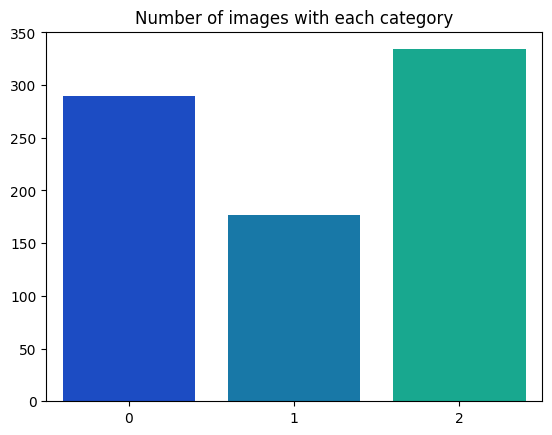

{0: 'large_head_on_boat', 1: 'crossing_boat', 2: 'overtaking_boat'}


In [10]:
cat_stats = {id : len(imgs) for id, imgs in data.catToImgs.items()}

sns.set_palette("winter", len(cat_stats))
sns.barplot(x=list(cat_stats.keys()), y= list(cat_stats.values())).set(title='Number of images with each category')
plt.show()
print(CLASSES)

In [11]:
images

[{'filename': 'CAM02_img034.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM02_img034'},
 {'filename': 'CAM02_img138.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM02_img138'},
 {'filename': 'CAM02_img001.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM02_img001'},
 {'filename': 'CAM01_img046.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM01_img046'},
 {'filename': 'CAM02_img112.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM02_img112'},
 {'filename': 'CAM02_img104.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM02_img104'},
 {'filename': 'CAM02_img069.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM02_img069'},
 {'filename': 'CAM00_img138.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM00_img138'},
 {'filename': 'CAM00_img090.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM00_img090'},
 {'filename': 'CAM01_img156.jpg',
  'height': 2056,
  'width': 2464,
  'id': 'CAM01_img156'},
 {'filename': 'CAM01_img017.jpg',
  'height': 2056,
  'width

In [ ]:
 {
                "X": -154.3535,
                "Y": 895.635498
            },
            {
                "X": 544.184143,
                "Y": 1098.72876
            }

In [23]:
data.loadAnns(data.getAnnIds('CAM00_img002'))

[{'area': 4020,
  'iscrowd': 0,
  'bbox': [2343, 914, 60, 67],
  'category_id': 0,
  'segmentation': [],
  'image_id': 'CAM00_img002',
  'id': 'CAM00_img002_0'},
 {'area': 141897,
  'iscrowd': 0,
  'bbox': [195, 997, 699, 203],
  'category_id': 1,
  'segmentation': [],
  'image_id': 'CAM00_img002',
  'id': 'CAM00_img002_1'},
 {'area': 53070,
  'iscrowd': 0,
  'bbox': [2575, 886, 305, 174],
  'category_id': 2,
  'segmentation': [],
  'image_id': 'CAM00_img002',
  'id': 'CAM00_img002_2'}]

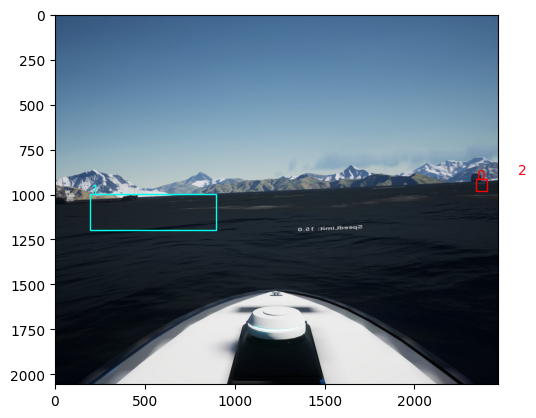

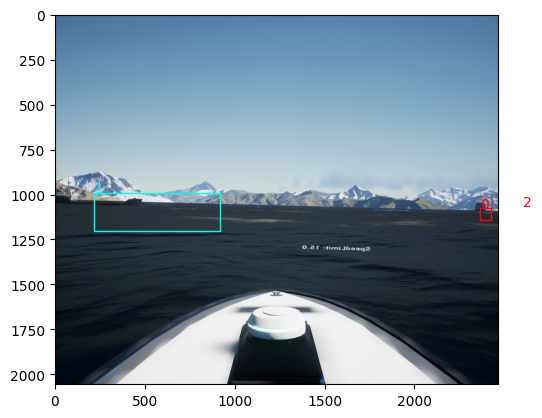

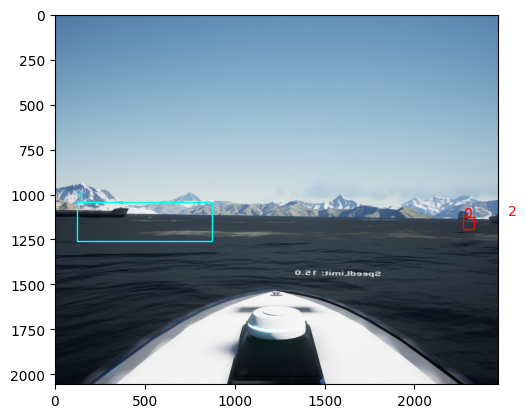

In [16]:
image_ids = ['CAM00_img002','CAM00_img003', 'CAM00_img004' ] 
#images_path = './hurtigruten/images/'

for image_id in image_ids:
    data.visualizeImage(image_id, IMAGES_PATH, image_type='.jpg')

In [17]:
l = [data.imgToAnns[imgId] for imgId in ['CAM00_img002','CAM00_img003', 'CAM00_img004' ]  if imgId in data.imgToAnns]

In [18]:
data.imgToAnns

defaultdict(list,
            {'CAM00_img045': [{'area': 16632,
               'iscrowd': 0,
               'bbox': [2579, 972, 189, 88],
               'category_id': 0,
               'segmentation': [],
               'image_id': 'CAM00_img045',
               'id': 'CAM00_img045_0'},
              {'area': 283810,
               'iscrowd': 0,
               'bbox': [2380, 927, 1010, 281],
               'category_id': 1,
               'segmentation': [],
               'image_id': 'CAM00_img045',
               'id': 'CAM00_img045_1'}],
             'CAM01_img152': [{'area': 6930,
               'iscrowd': 0,
               'bbox': [619, 1028, 70, 99],
               'category_id': 2,
               'segmentation': [],
               'image_id': 'CAM01_img152',
               'id': 'CAM01_img152_0'}],
             'CAM02_img029': [{'area': 316394,
               'iscrowd': 0,
               'bbox': [2772, 1034, 1118, 283],
               'category_id': 1,
               'segmentat

In [19]:
ids =['CAM00_img002','CAM00_img003', 'CAM00_img004' ]

In [20]:
data.anns

{'CAM00_img045_0': {'area': 16632,
  'iscrowd': 0,
  'bbox': [2579, 972, 189, 88],
  'category_id': 0,
  'segmentation': [],
  'image_id': 'CAM00_img045',
  'id': 'CAM00_img045_0'},
 'CAM00_img045_1': {'area': 283810,
  'iscrowd': 0,
  'bbox': [2380, 927, 1010, 281],
  'category_id': 1,
  'segmentation': [],
  'image_id': 'CAM00_img045',
  'id': 'CAM00_img045_1'},
 'CAM01_img152_0': {'area': 6930,
  'iscrowd': 0,
  'bbox': [619, 1028, 70, 99],
  'category_id': 2,
  'segmentation': [],
  'image_id': 'CAM01_img152',
  'id': 'CAM01_img152_0'},
 'CAM02_img029_0': {'area': 316394,
  'iscrowd': 0,
  'bbox': [2772, 1034, 1118, 283],
  'category_id': 1,
  'segmentation': [],
  'image_id': 'CAM02_img029',
  'id': 'CAM02_img029_0'},
 'CAM01_img158_0': {'area': 8080,
  'iscrowd': 0,
  'bbox': [785, 997, 80, 101],
  'category_id': 2,
  'segmentation': [],
  'image_id': 'CAM01_img158',
  'id': 'CAM01_img158_0'},
 'CAM01_img015_0': {'area': 5037,
  'iscrowd': 0,
  'bbox': [-172, 1045, 69, 73],
  'ca

In [21]:
data

In [22]:
multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)

IndentationError: unexpected indent (3411035235.py, line 2)

In [ ]:
"annotations": [
    {
      "area": 2376,
      "iscrowd": 0,
      "bbox": [
        1007,
        458,
        72,
        33
      ],
      "category_id": 1,
      "ignore": 0,
      "segmentation": [],
      "image_id": 0,
      "id": 1
    },

In [ ]:
dataset_path = os.path.join(DATASET_DIR, 'coco_hurtigruten.json')
data = COCO(dataset_path)
CLASSES = {id: cat['name'] for id, cat in data.cats.items()}

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/solveijm/DNV_dataset/coco_hurtigruten.json'